# Mean Shift 모델, 입력 데이터는 outline data

## import libraries

In [3]:
import requests
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

## Azure keys(사용자 입력)

## Custom vision 결과 확인 및 크롭

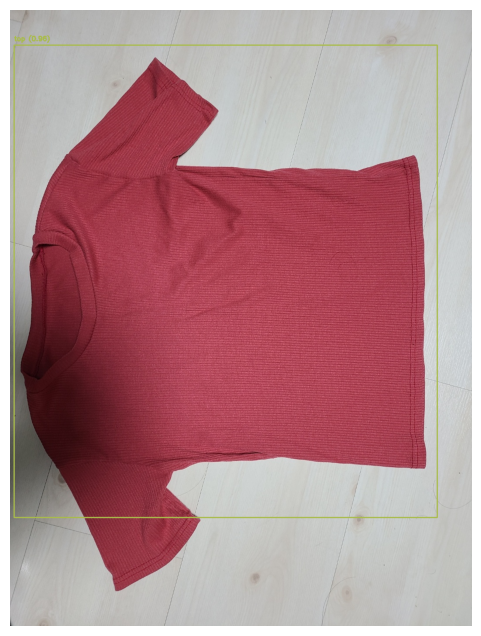

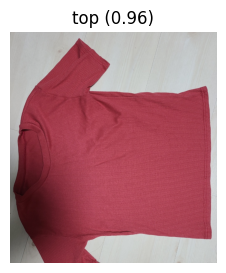

Tag: top, Probability: 0.96, Image Shape: (1082, 969, 3)


In [ ]:
## Custom Vision 결과 확인
# 임계값 설정
THRESHOLD = 0.8  # 70% 이상 확률만 표시

# 카테고리별 색상 저장용 딕셔너리
category_colors = defaultdict(lambda: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

def detect_objects(image_path):
    # 이미지 로드
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    # API 요청 헤더 및 데이터
    headers = {
        "Prediction-Key": prediction_key,
        "Content-Type": "application/octet-stream"
    }
    url = f"{prediction_endpoint}/customvision/v3.0/Prediction/{project_id}/detect/iterations/{model_name}/image"
    
    # 요청 전송
    response = requests.post(url, headers=headers, data=image_data)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return None

    # JSON 응답 데이터 파싱
    return response.json()

def visualize_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < THRESHOLD:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 정보 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 카테고리별 색상 선택
        color = category_colors[tag_name]

        # 바운딩 박스 및 텍스트 추가
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"{tag_name} ({probability:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 결과 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# 실행 예시
image_file = f"data/test_image/test19.jpeg"
detections = detect_objects(image_file)
if detections:
    visualize_detections(image_file, detections)


## 필요한 부분만 가져오기
def show_cropped_objects_clean(image_path, detections, threshold=THRESHOLD):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cropped_images = []  # 크롭된 이미지를 저장할 리스트

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < threshold:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 좌표 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 객체 부분 잘라내기
        cropped_object = image[y1:y2, x1:x2]
        cropped_images.append((tag_name, probability, cropped_object))  # (라벨, 확률, 이미지) 저장

        # 새 창에 개별 이미지 출력
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_object)
        plt.title(f"{tag_name} ({probability:.2f})")
        plt.axis("off")
        plt.show()

    return cropped_images  # 크롭된 이미지 리스트 반환

# 실행 예시
cropped_objects = show_cropped_objects_clean(image_file, detections)

# 반환된 이미지 확인
for tag, prob, img in cropped_objects:
    print(f"Tag: {tag}, Probability: {prob:.2f}, Image Shape: {img.shape}")



## 배경 제거

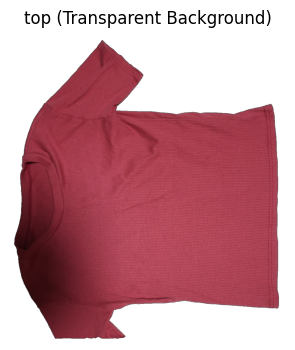

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_background(cropped_images):
    final_images = []  # 최종 결과 저장

    for tag, prob, img in cropped_images:
        h, w, _ = img.shape
        
        # 초기 마스크 설정
        mask = np.zeros((h, w), np.uint8)
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)
        
        # GrabCut을 위한 초기 사각형 (조금 작게 설정)
        rect = (5, 5, w-10, h-10)
        cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
        
        # 배경과 전경 분리
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
        result = img * mask2[:, :, np.newaxis]
        
        # 경계 부드럽게 (가우시안 블러 적용)
        blurred = cv2.GaussianBlur(result, (5, 5), 0)

        # 알파 채널 추가
        alpha = mask2 * 255
        rgba = np.dstack([blurred, alpha])

        # 📌 최종 이미지 출력
        plt.figure(figsize=(4, 4))
        plt.imshow(rgba)
        plt.title(f"{tag} (Transparent Background)", fontsize=12)
        plt.axis("off")
        plt.show()

        final_images.append((tag, rgba))  # 결과 저장
    
    return final_images  # 최종 이미지 반환

# 🔥 실행
final_results = remove_background(cropped_objects)




## Mean Shift

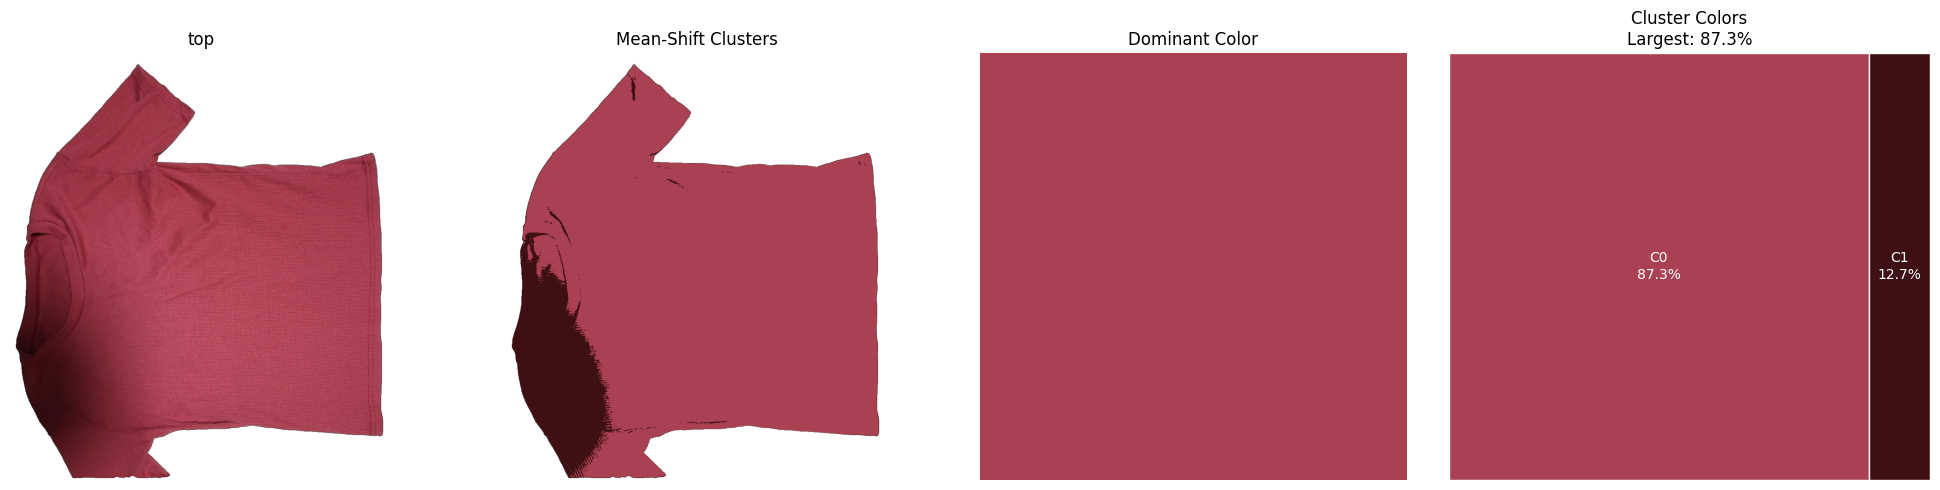

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

def plot_cluster_color_bar(ax, sorted_clusters, total_pixels):
    """
    클러스터별 평균 색상과 픽셀 비율을 바탕으로 색상 바를 생성.
    """
    left = 0.0
    for label, (mean_color, count) in sorted_clusters:
        proportion = count / total_pixels
        color = np.array(mean_color[:3]) / 255.0
        
        rect = plt.Rectangle((left, 0), proportion, 1, 
                           facecolor=color, 
                           edgecolor='white')
        ax.add_patch(rect)
        
        text_color = 'black' if np.mean(color) > 0.5 else 'white'
        ax.text(left + proportion/2, 0.5, 
                f"C{label}\n{proportion*100:.1f}%",
                ha='center', va='center', 
                fontsize=10, 
                color=text_color)
        left += proportion
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

def show_all_transparent_visualizations(final_results, quantile=0.2, n_samples=1000):
    """
    배경이 제거된 RGBA 이미지들을 Mean-Shift로 분석하여 시각화
    """
    n = len(final_results)
    if n == 0:
        print("표시할 이미지가 없습니다.")
        return
    
    fig, axes = plt.subplots(n, 4, figsize=(20, 5 * n))
    if n == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i, (tag, rgba_img) in enumerate(final_results):
        # 원본 크기 저장
        original_shape = rgba_img.shape[:2]
        
        # 원본 이미지 표시
        axes[i, 0].imshow(rgba_img)
        axes[i, 0].set_title(f"{tag}")
        axes[i, 0].axis("off")
        
        # 투명하지 않은 픽셀만 선택
        mask = rgba_img[:, :, 3] > 0
        pixels = rgba_img[mask][:, :3]  # RGB 값만 사용
        pixel_positions = np.argwhere(mask)  # 픽셀 위치 저장
        
        if len(pixels) == 0:
            print(f"이미지 {tag}에 표시할 픽셀이 없습니다.")
            continue
            
        # Mean-Shift 클러스터링
        bandwidth = estimate_bandwidth(pixels, 
                                    quantile=quantile, 
                                    n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        
        # 클러스터링 수행
        labels = ms.fit_predict(pixels)
        cluster_centers = ms.cluster_centers_.astype(int)
        
        # 클러스터링 결과 이미지 생성
        cluster_image = np.zeros_like(rgba_img)
        
        # 각 픽셀을 원래 위치에 클러스터 색상으로 채우기
        for pos, label in zip(pixel_positions, labels):
            cluster_image[pos[0], pos[1]] = np.append(cluster_centers[label], 255)
        
        # 클러스터링 결과 표시 (픽셀화된 형태로)
        axes[i, 1].imshow(cluster_image)
        axes[i, 1].set_title("Mean-Shift Clusters")
        axes[i, 1].axis("off")
        
        # 주요 색상 표시
        counts = np.bincount(labels)
        dominant_label = np.argmax(counts)
        dominant_color = np.append(cluster_centers[dominant_label], 255)
        dominant_patch = np.full((50, 50, 4), dominant_color, dtype=np.uint8)
        axes[i, 2].imshow(dominant_patch)
        axes[i, 2].set_title("Dominant Color")
        axes[i, 2].axis("off")
        
        # 색상 바 표시
        total_pixels = len(pixels)
        cluster_info = {label: (np.append(cluster_centers[label], 255), count) 
                       for label, count in zip(range(len(cluster_centers)), counts)}
        sorted_clusters = sorted(cluster_info.items(), 
                               key=lambda x: x[1][1], 
                               reverse=True)
        plot_cluster_color_bar(axes[i, 3], sorted_clusters, total_pixels)
        
        largest_percentage = (sorted_clusters[0][1][1] / total_pixels) * 100
        axes[i, 3].set_title(f"Cluster Colors\nLargest: {largest_percentage:.1f}%")
    
    plt.tight_layout()
    plt.show()

# 실행
show_all_transparent_visualizations(final_results, quantile=0.2, n_samples=1000)

## Hex code로 색

In [30]:
def get_dominant_color_hex(final_results, quantile=0.2, n_samples=1000):
    """
    배경이 제거된 RGBA 이미지에서 가장 많이 등장하는 색상의 HEX 코드를 반환
    """
    hex_codes = {}

    for tag, rgba_img in final_results:
        # 투명하지 않은 픽셀만 선택
        mask = rgba_img[:, :, 3] > 0
        pixels = rgba_img[mask][:, :3]  # RGB 값만 사용

        if len(pixels) == 0:
            print(f"이미지 {tag}에 표시할 픽셀이 없습니다.")
            hex_codes[tag] = None
            continue

        # Mean-Shift 클러스터링
        bandwidth = estimate_bandwidth(pixels, quantile=quantile, n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels = ms.fit_predict(pixels)
        cluster_centers = ms.cluster_centers_.astype(int)

        # 가장 많이 등장한 클러스터 찾기
        counts = np.bincount(labels)
        dominant_label = np.argmax(counts)
        dominant_color = cluster_centers[dominant_label]

        # RGB를 HEX 코드로 변환
        hex_code = "#{:02x}{:02x}{:02x}".format(*dominant_color)
        hex_codes[tag] = hex_code

    return hex_codes

# 실행 예시
dominant_colors = get_dominant_color_hex(final_results, quantile=0.2, n_samples=1000)
print(dominant_colors)

{'top': '#aa4152'}
